## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'efficientnet-exp001'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 32 # 16
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 15 # 30

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 3 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

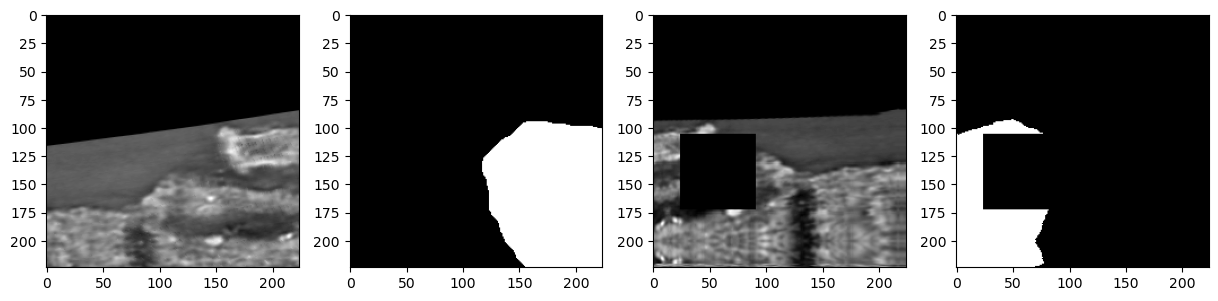

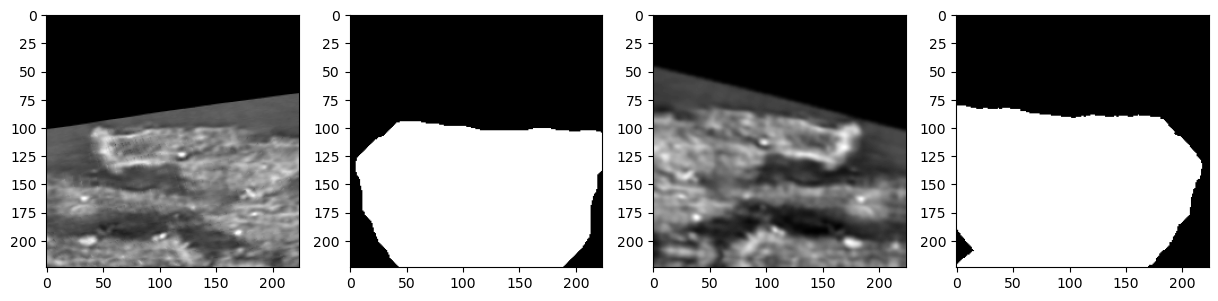

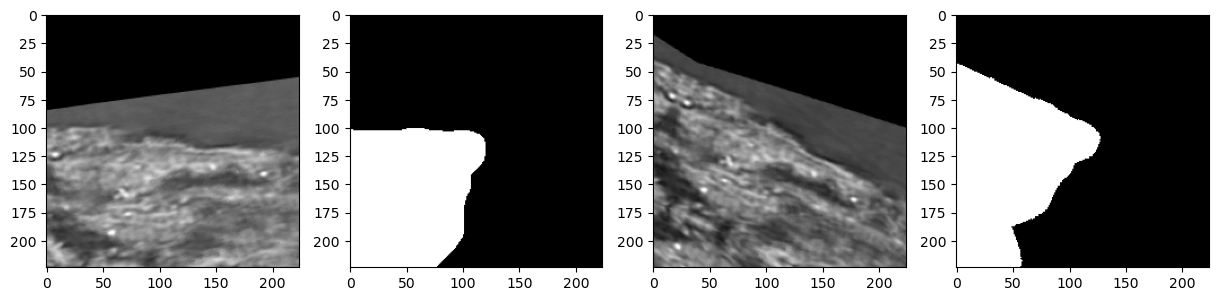

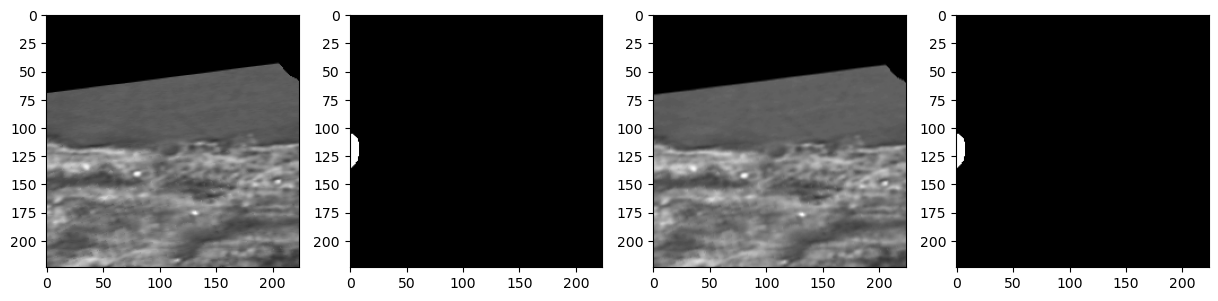

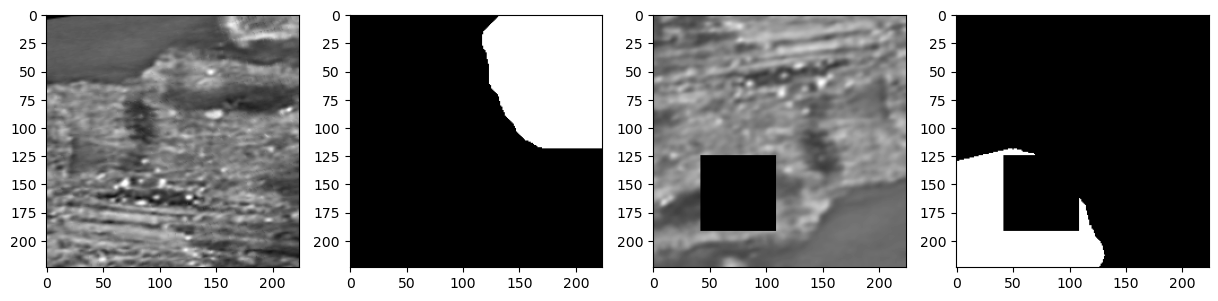

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48130

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone efficientnet-b0


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.09501730013634668
th: 0.15, fbeta: 0.0950269593772805
th: 0.2, fbeta: 0.09503019912875278
th: 0.25, fbeta: 0.09493288804300089
th: 0.3, fbeta: 0.09463374818068289
th: 0.35, fbeta: 0.13869337492609435
th: 0.4, fbeta: 0.15596075457311212
th: 0.45, fbeta: 0.16009595522614922


best_th: 0.45, fbeta: 0.16009595522614922
Epoch 1 - avg_train_loss: 0.6962  avg_val_loss: 0.5394  time: 182s
Epoch 1 - avgScore: 0.1601
Epoch 1 - Save Best Score: 0.1601 Model
Epoch 1 - Save Best Loss: 0.5394 Model


th: 0.5, fbeta: 0.15405878906619477


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.09501513500504266
th: 0.15, fbeta: 0.09505837949059065
th: 0.2, fbeta: 0.11460641399163202
th: 0.25, fbeta: 0.15897167951410157
th: 0.3, fbeta: 0.181691384352429
th: 0.35, fbeta: 0.21547107768868934
th: 0.4, fbeta: 0.24157151392131623
th: 0.45, fbeta: 0.2385225416197145


best_th: 0.4, fbeta: 0.24157151392131623
Epoch 2 - avg_train_loss: 0.4828  avg_val_loss: 0.3962  time: 186s
Epoch 2 - avgScore: 0.2416
Epoch 2 - Save Best Score: 0.2416 Model
Epoch 2 - Save Best Loss: 0.3962 Model


th: 0.5, fbeta: 0.16964085646319702


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.19972153758001893
th: 0.15, fbeta: 0.27213116721640196
th: 0.2, fbeta: 0.3462697234277198
th: 0.25, fbeta: 0.399801322748929
th: 0.3, fbeta: 0.43629537849195227
th: 0.35, fbeta: 0.4584688204478954
th: 0.4, fbeta: 0.4735259012717498
th: 0.45, fbeta: 0.48243031017874366


best_th: 0.45, fbeta: 0.48243031017874366
Epoch 3 - avg_train_loss: 0.3025  avg_val_loss: 0.2116  time: 187s
Epoch 3 - avgScore: 0.4824
Epoch 3 - Save Best Score: 0.4824 Model
Epoch 3 - Save Best Loss: 0.2116 Model


th: 0.5, fbeta: 0.47721672102391205


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.239911366171144
th: 0.15, fbeta: 0.3169719291297263
th: 0.2, fbeta: 0.3868220132975622
th: 0.25, fbeta: 0.4468100295570616
th: 0.3, fbeta: 0.4903105572168529
th: 0.35, fbeta: 0.512304406533951
th: 0.4, fbeta: 0.5196195005900349
th: 0.45, fbeta: 0.49666630850251897


best_th: 0.4, fbeta: 0.5196195005900349
Epoch 4 - avg_train_loss: 0.2537  avg_val_loss: 0.1986  time: 188s
Epoch 4 - avgScore: 0.5196
Epoch 4 - Save Best Score: 0.5196 Model
Epoch 4 - Save Best Loss: 0.1986 Model


th: 0.5, fbeta: 0.44912232748213854


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.19189487415965645
th: 0.15, fbeta: 0.22208569287504332
th: 0.2, fbeta: 0.2571388119590091
th: 0.25, fbeta: 0.2915443234208763
th: 0.3, fbeta: 0.32331978622673935
th: 0.35, fbeta: 0.3536272614809636
th: 0.4, fbeta: 0.3832323791589568
th: 0.45, fbeta: 0.41412277247751383


best_th: 0.5, fbeta: 0.4443613858726432
Epoch 5 - avg_train_loss: 0.2414  avg_val_loss: 0.2464  time: 188s
Epoch 5 - avgScore: 0.4444


th: 0.5, fbeta: 0.4443613858726432


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.24222894818580026
th: 0.15, fbeta: 0.28031932224682066
th: 0.2, fbeta: 0.3190785323320395
th: 0.25, fbeta: 0.35522626942803054
th: 0.3, fbeta: 0.3908431068826782
th: 0.35, fbeta: 0.4224873814321035
th: 0.4, fbeta: 0.45052279597705613
th: 0.45, fbeta: 0.47468551154850486


best_th: 0.5, fbeta: 0.4977317964922643
Epoch 6 - avg_train_loss: 0.2359  avg_val_loss: 0.2107  time: 188s
Epoch 6 - avgScore: 0.4977


th: 0.5, fbeta: 0.4977317964922643


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.278079791124754
th: 0.15, fbeta: 0.3331681625959893
th: 0.2, fbeta: 0.3811417515113423
th: 0.25, fbeta: 0.4313076804545703
th: 0.3, fbeta: 0.47523806714684214
th: 0.35, fbeta: 0.5075846164760992
th: 0.4, fbeta: 0.5287717241172247
th: 0.45, fbeta: 0.5356900289837319


best_th: 0.45, fbeta: 0.5356900289837319
Epoch 7 - avg_train_loss: 0.2308  avg_val_loss: 0.1921  time: 188s
Epoch 7 - avgScore: 0.5357
Epoch 7 - Save Best Score: 0.5357 Model
Epoch 7 - Save Best Loss: 0.1921 Model


th: 0.5, fbeta: 0.5346938591255541


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.22891554676758175
th: 0.15, fbeta: 0.279134380535777
th: 0.2, fbeta: 0.32188956727710605
th: 0.25, fbeta: 0.3655764295701918
th: 0.3, fbeta: 0.4122148906899825
th: 0.35, fbeta: 0.45581900096620376
th: 0.4, fbeta: 0.4893566886759098
th: 0.45, fbeta: 0.5201471822958172


best_th: 0.5, fbeta: 0.5425751583492467
Epoch 8 - avg_train_loss: 0.2249  avg_val_loss: 0.2006  time: 188s
Epoch 8 - avgScore: 0.5426
Epoch 8 - Save Best Score: 0.5426 Model
Epoch 8 - Save Best Loss: 0.2006 Model


th: 0.5, fbeta: 0.5425751583492467


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23047927788336015
th: 0.15, fbeta: 0.2668815297401024
th: 0.2, fbeta: 0.30149326131924326
th: 0.25, fbeta: 0.3335427751897642
th: 0.3, fbeta: 0.3642219812611607
th: 0.35, fbeta: 0.391668668422874
th: 0.4, fbeta: 0.41846039130938134
th: 0.45, fbeta: 0.4421941180060631


best_th: 0.5, fbeta: 0.4648561910385773
Epoch 9 - avg_train_loss: 0.2199  avg_val_loss: 0.2267  time: 187s
Epoch 9 - avgScore: 0.4649


th: 0.5, fbeta: 0.4648561910385773


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2776758201618177
th: 0.15, fbeta: 0.3274663628869535
th: 0.2, fbeta: 0.36811007114942224
th: 0.25, fbeta: 0.4024271484132984
th: 0.3, fbeta: 0.43595832268425483
th: 0.35, fbeta: 0.4671963374317797
th: 0.4, fbeta: 0.4958644230843097
th: 0.45, fbeta: 0.5194215694520733


best_th: 0.5, fbeta: 0.5306118452260103
Epoch 10 - avg_train_loss: 0.2132  avg_val_loss: 0.1974  time: 188s
Epoch 10 - avgScore: 0.5306


th: 0.5, fbeta: 0.5306118452260103


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.22985673499640968
th: 0.15, fbeta: 0.26114145091524243
th: 0.2, fbeta: 0.2925928429917421
th: 0.25, fbeta: 0.32236969899344464
th: 0.3, fbeta: 0.3510693526178064
th: 0.35, fbeta: 0.3789014247735809
th: 0.4, fbeta: 0.40749421533805624
th: 0.45, fbeta: 0.4370648058783459


best_th: 0.5, fbeta: 0.4640856893586018
Epoch 11 - avg_train_loss: 0.2087  avg_val_loss: 0.2271  time: 188s
Epoch 11 - avgScore: 0.4641


th: 0.5, fbeta: 0.4640856893586018


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.22728850190927838
th: 0.15, fbeta: 0.2583071033877509
th: 0.2, fbeta: 0.2863349286582468
th: 0.25, fbeta: 0.31316819799669676
th: 0.3, fbeta: 0.3395756784031809
th: 0.35, fbeta: 0.3651233493627462
th: 0.4, fbeta: 0.3875357630749695
th: 0.45, fbeta: 0.4117911484593689


best_th: 0.5, fbeta: 0.43668975716596875
Epoch 12 - avg_train_loss: 0.2052  avg_val_loss: 0.2434  time: 188s
Epoch 12 - avgScore: 0.4367


th: 0.5, fbeta: 0.43668975716596875


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23371597421258916
th: 0.15, fbeta: 0.264985196038043
th: 0.2, fbeta: 0.29536309478227846
th: 0.25, fbeta: 0.32362808359456396
th: 0.3, fbeta: 0.35163314657533445
th: 0.35, fbeta: 0.37753427060559264
th: 0.4, fbeta: 0.4039645620758785
th: 0.45, fbeta: 0.4326247099596347


best_th: 0.5, fbeta: 0.45863631955413714
Epoch 13 - avg_train_loss: 0.2027  avg_val_loss: 0.2294  time: 187s
Epoch 13 - avgScore: 0.4586


th: 0.5, fbeta: 0.45863631955413714


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2772762668884001
th: 0.15, fbeta: 0.3218750093095299
th: 0.2, fbeta: 0.36166854916633684
th: 0.25, fbeta: 0.396545988909613
th: 0.3, fbeta: 0.42637925521461656
th: 0.35, fbeta: 0.455168981730842
th: 0.4, fbeta: 0.4778948645494172
th: 0.45, fbeta: 0.49821825381745616


best_th: 0.5, fbeta: 0.518107460028359
Epoch 14 - avg_train_loss: 0.2000  avg_val_loss: 0.2024  time: 188s
Epoch 14 - avgScore: 0.5181


th: 0.5, fbeta: 0.518107460028359


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.24887574050797717
th: 0.15, fbeta: 0.2842728969154705
th: 0.2, fbeta: 0.3132966446517991
th: 0.25, fbeta: 0.3425292992463454
th: 0.3, fbeta: 0.36861130048622237
th: 0.35, fbeta: 0.3942591102823174
th: 0.4, fbeta: 0.4204725451184761
th: 0.45, fbeta: 0.4471752956908016


best_th: 0.5, fbeta: 0.4696779122588896
Epoch 15 - avg_train_loss: 0.1976  avg_val_loss: 0.2235  time: 187s
Epoch 15 - avgScore: 0.4697


th: 0.5, fbeta: 0.4696779122588896


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.22891554676758175
th: 0.15, fbeta: 0.279134380535777
th: 0.2, fbeta: 0.32188956727710605
th: 0.25, fbeta: 0.3655764295701918
th: 0.3, fbeta: 0.4122148906899825
th: 0.35, fbeta: 0.45581900096620376
th: 0.4, fbeta: 0.4893566886759098
th: 0.45, fbeta: 0.5201471822958172


best_th: 0.5, fbeta: 0.5425751583492467


th: 0.5, fbeta: 0.5425751583492467


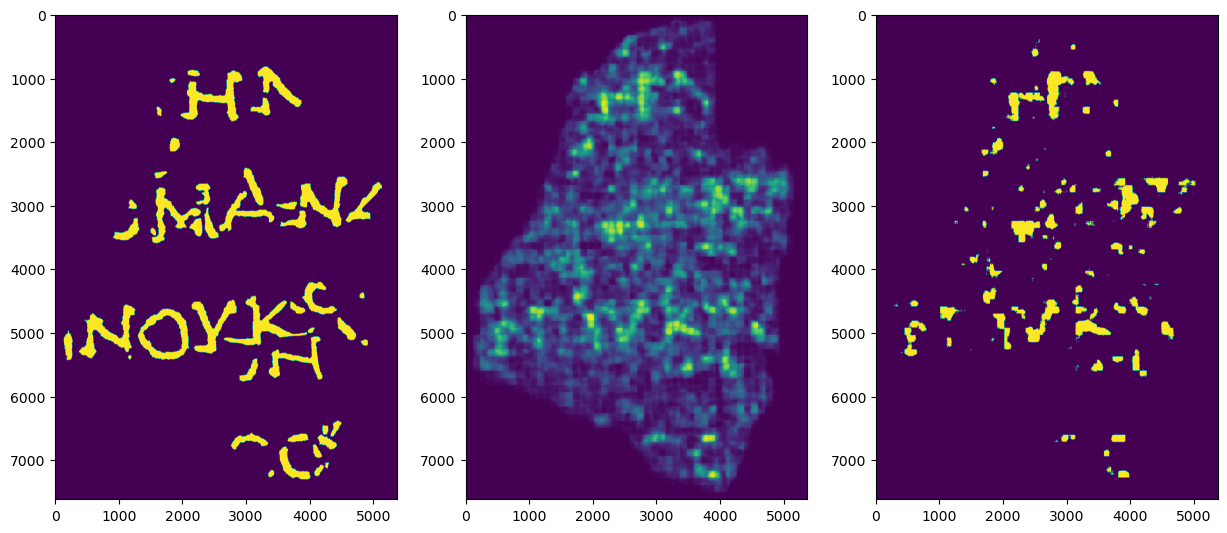

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([1.9825543e+07, 4.7356760e+06, 3.9075020e+06, 2.8824810e+06,
        2.2208390e+06, 1.7694010e+06, 1.2711570e+06, 9.6117600e+05,
        7.4581400e+05, 5.9047800e+05, 4.5201000e+05, 3.6373800e+05,
        3.0054700e+05, 2.5387300e+05, 2.0506400e+05, 1.6453800e+05,
        1.3952800e+05, 9.9333000e+04, 4.2516000e+04, 1.2402000e+04]),
 array([3.12111828e-04, 4.69083197e-02, 9.35045276e-02, 1.40100735e-01,
        1.86696943e-01, 2.33293151e-01, 2.79889359e-01, 3.26485567e-01,
        3.73081775e-01, 4.19677983e-01, 4.66274190e-01, 5.12870398e-01,
        5.59466606e-01, 6.06062814e-01, 6.52659022e-01, 6.99255230e-01,
        7.45851438e-01, 7.92447646e-01, 8.39043853e-01, 8.85640061e-01,
        9.32236269e-01]),
 <BarContainer object of 20 artists>)

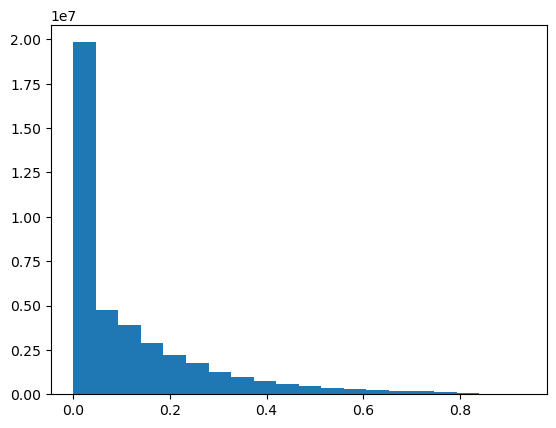

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000